Instructions:
Use the Titanic dataset to experiment with the different evaluation methods we have looked at:

PrecisionRecallDisplay
RocCurveDisplay
Learning_curve
Validation_curve (for at least 3 parameters)

For each, read the documentation, compute the graphs and give your analysis / explanation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn 
print(sklearn.__version__)

1.3.0


In [2]:
titanic = pd.read_csv("titanic.csv")
titanic.shape

(891, 12)

In [3]:
titanic.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
484,485,1,1,"Bishop, Mr. Dickinson H",male,25.0,1,0,11967,91.0792,B49,C
432,433,1,2,"Louch, Mrs. Charles Alexander (Alice Adelaide ...",female,42.0,1,0,SC/AH 3085,26.0000,NaN,S
286,287,1,3,"de Mulder, Mr. Theodore",male,30.0,0,0,345774,9.5000,NaN,S
626,627,0,2,"Kirkland, Rev. Charles Leonard",male,57.0,0,0,219533,12.3500,NaN,Q
237,238,1,2,"Collyer, Miss. Marjorie ""Lottie""",female,8.0,0,2,C.A. 31921,26.2500,NaN,S


In [4]:
titanic.duplicated().sum()

0

In [5]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
titanic.drop(columns= ['Cabin'], inplace=True)
titanic.dropna(subset=['Embarked'], inplace=True)

### Set Up Train and Test Partitions

In [8]:
y = titanic.Survived
X = titanic.drop(columns=['Survived']) 
X.shape, y.shape

((889, 10), (889,))

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.compose import make_column_transformer 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .50, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((444, 10), (445, 10), (444,), (445,))

In [14]:
ohe = OneHotEncoder()
imputer = KNNImputer()
scaler = StandardScaler()
logreg = LogisticRegression(random_state=42) 

numeric_preprocessing = make_pipeline(imputer, scaler)
categorical_preprocessing = make_pipeline(ohe)
preprocessor = make_column_transformer(
    (numeric_preprocessing, ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']),
    (categorical_preprocessing, ['Sex', 'Embarked']),
    remainder='drop')

pipe = make_pipeline (preprocessor, logreg)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare', 'Pclass']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'Embarked'])])),
                ('logisticregression', LogisticRegression(random_state=42))])

### Model evaluation

In [18]:
param_grid = [{
    'columntransformer__pipeline-1__knnimputer__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9], 
    'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000]}]
gs = GridSearchCV(pipe, param_grid, cv=10, scoring='f1_macro', n_jobs=-1, verbose=1, refit=True)
gs.fit(X_train, y_train) 

Fitting 10 folds for each of 63 candidates, totalling 630 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('knnimputer',
                                                                                          KNNImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare',
                                                                          'Pclass']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex',
                                                                          'Embarked'])])),
                                       ('logisticregression',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'columntransformer__pipeline-1__knnimputer__n_neighbors': [1,
                                                                                     2,
                                                                                     3,
                                                                                     4,
                                                                                     5,
                                                                                     6,
                                                                                     7,
                                                                                     8,
                                                                                     9],
                          'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10,
                                                    100, 1000]}],
             scoring='f1_macro', verbose=1)

In [19]:
gs.best_score_

0.782434162012935

In [20]:
gs.best_params_

{'columntransformer__pipeline-1__knnimputer__n_neighbors': 1,
 'logisticregression__C': 10}

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       275
           1       0.82      0.70      0.76       170

    accuracy                           0.83       445
   macro avg       0.83      0.80      0.81       445
weighted avg       0.83      0.83      0.82       445



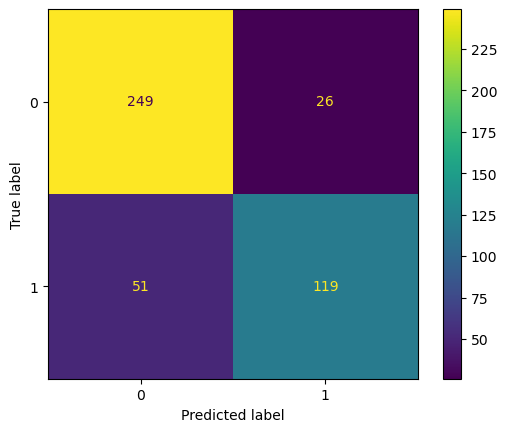

In [23]:
X_test_predictions = gs.predict(X_test)
print(classification_report(y_test, X_test_predictions))
ConfusionMatrixDisplay.from_predictions(y_test, X_test_predictions);

### Qualitative Error Analysis

In [24]:
d = {'true': y_test, 'pred': X_test_predictions, 'id': X_test.PassengerId}
output = pd.DataFrame(data=d)
output.sample(3)

,true,pred,id
391,1,0,392
329,1,1,330
813,0,0,814


In [46]:
print('False negatives:')
false_negatives = (output['true'] == 1) & (output['pred'] == 0)
false_negative_ids = output[false_negatives].id
false_negative_records = titanic[titanic['PassengerId'].isin(false_negative_ids)]
false_negative_records.head(3)

False negatives:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,S
25,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,S
55,56,1,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,S


In [25]:
print('False positives:')
false_positives = (output['true'] == 0) & (output['pred'] == 1)
false_positive_ids = output[false_positives].id
false_positive_records = titanic[titanic['PassengerId'].isin(false_positive_ids)]
false_positive_records.head(3)

False positives:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
49,50,0,3,"Arnold-Franchi, Mrs. Josef (Josefine Franchi)",female,18.0,1,0,349237,17.8000,S
83,84,0,1,"Carrau, Mr. Francisco M",male,28.0,0,0,113059,47.1000,S
100,101,0,3,"Petranec, Miss. Matilda",female,28.0,0,0,349245,7.8958,S


### Learning curve

In [28]:
from sklearn.model_selection import learning_curve, validation_curve

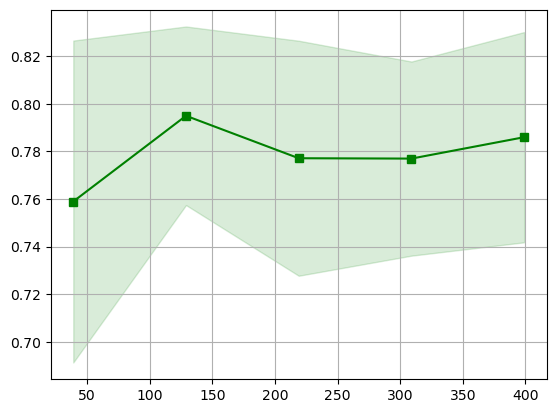

In [29]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe, X=X_train, y=y_train, cv=10)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, test_mean, color='green', marker='s')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()

### Validation curve

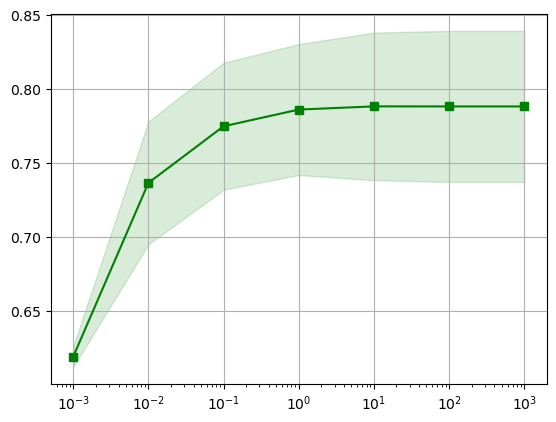

In [30]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
train_scores, test_scores = validation_curve(estimator=pipe, X=X_train, y=y_train, \
                                             param_name= 'logisticregression__C', param_range=param_range, cv=10)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, test_mean, color='green', marker='s')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.show()

### PrecisionRecallDisplay

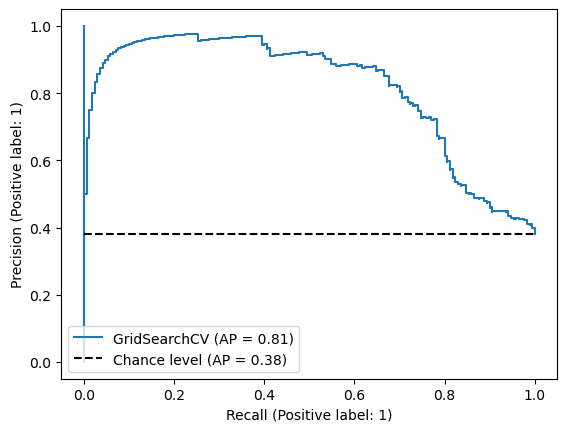

In [36]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

PrecisionRecallDisplay.from_estimator(gs, X_test, y_test, plot_chance_level=True);

### RocCurveDisplay


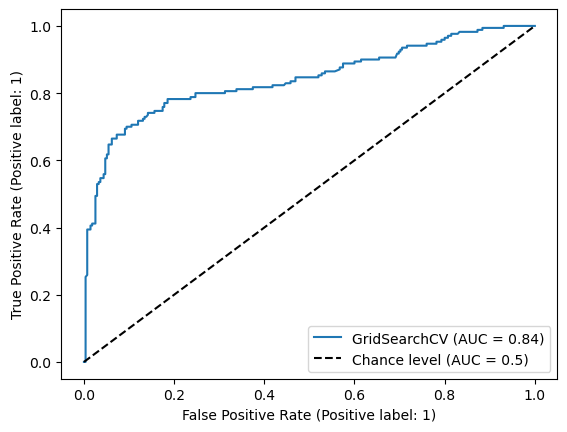

In [34]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(gs, X_test, y_test, plot_chance_level=True);